In [21]:
!pip install torch torch_geometric torch_scatter torch_sparse torch_cluster torch_spline_conv pandas numpy requests scikit-learn imbalanced-learn xgboost tensorflow shap lime matplotlib

# Step 1: Data Acquisition

In [22]:
import requests
import pandas as pd
import numpy as np

ETHERSCAN_API_KEY = "V8RHS7P2YNSAHUY92CXVANVQK8MIYK95UQ"
BASE_URL = "https://api.etherscan.io/api"

def get_transactions(address, start_block=0, end_block=99999999):
    params = {
        'module': 'account',
        'action': 'txlist',
        'address': address,
        'startblock': start_block,
        'endblock': end_block,
        'sort': 'asc',
        'apikey': ETHERSCAN_API_KEY
    }
    response = requests.get(BASE_URL, params=params)
    return response.json()['result']

normal_addresses = [
    "0x742d35Cc6634C0532925a3b844Bc454e4438f44e",
    "0xDC76CD25977E0a5Ae17155770273aD58648900D3",
    "0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0",
]

fraud_addresses = [
    "0x283aa3c6e0cf2c2d8f2c1c3b7603e7b4c8a9f2a6",
    "0x6f46cf5569aefa1acc1009290c8e043747172d89",
]

normal_txns = [get_transactions(addr) for addr in normal_addresses]
fraud_txns = [get_transactions(addr) for addr in fraud_addresses]

normal_df = pd.DataFrame([tx for sublist in normal_txns for tx in sublist])
normal_df['is_fraud'] = 0
fraud_df = pd.DataFrame([tx for sublist in fraud_txns for tx in sublist])
fraud_df['is_fraud'] = 1
df = pd.concat([normal_df, fraud_df], axis=0)


# Step 2: Data Preprocessing & Feature Engineering

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime

def preprocess_data(df):
    # Remove non-numeric columns for ML
    non_numeric = ['hash', 'nonce', 'blockHash', 'from', 'to', 'input', 'contractAddress', 'cumulativeGasUsed', 'blockNumber', 'timeStamp', 'transactionIndex']
    for col in non_numeric:
        if col in df.columns:
            df = df.drop(columns=[col])
    # Convert timestamp first for features
    if 'timeStamp' in df.columns:
        df['timestamp'] = df['timeStamp'].apply(lambda x: datetime.fromtimestamp(int(x)))
    else:
        df['timestamp'] = pd.to_datetime('now')
    # Feature engineering
    df['value_eth'] = df['value'].astype(float) / 1e18
    df['gas_price_gwei'] = df['gasPrice'].astype(float) / 1e9
    df['gas_used'] = df['gasUsed'].astype(float)
    df['gas_cost'] = df['gas_price_gwei'] * df['gas_used']
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['value_gas_ratio'] = df['value_eth'] / (df['gas_cost'] + 1e-9)
    # Add sender/receiver txn count (optional, but requires original from/to columns)
    df['sender_txn_count'] = 1  # Dummy if dropped
    df['receiver_txn_count'] = 1
    # Select features
    features = [
        'value_eth', 'gas_price_gwei', 'gas_used', 'gas_cost',
        'hour_of_day', 'day_of_week', 'is_weekend', 'value_gas_ratio',
        'sender_txn_count', 'receiver_txn_count'
    ]
    X = df[features]
    y = df['is_fraud']
    return X, y

X, y = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Step 3: Class Balancing

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
resample_pipeline = Pipeline([
    ('o', over),
    ('u', under)
])
X_train_res, y_train_res = resample_pipeline.fit_resample(X_train, y_train)


# Step 4: Model Building

## XGBoost Model


In [25]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=(len(y_train_res) - sum(y_train_res)) / sum(y_train_res)
)
xgb_model.fit(X_train_scaled, y_train_res)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4159
           1       0.36      0.96      0.52       100

    accuracy                           0.96      4259
   macro avg       0.68      0.96      0.75      4259
weighted avg       0.98      0.96      0.97      4259

ROC-AUC: 0.9846585717720606


## LSTM Model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

# We create sequences using only numeric features
def create_sequences(X, y, sequence_length=10):
    sequences, labels = [], []
    for i in range(len(X) - sequence_length):
        seq = X.iloc[i:i+sequence_length].values
        label = y.iloc[i+sequence_length-1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X_sequences, y_sequences = create_sequences(X, y)
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)
# Resample: flatten to 2D, resample, then reshape
X_seq_train_2d = X_seq_train.reshape(X_seq_train.shape[0], -1)
X_seq_train_res, y_seq_train_res = resample_pipeline.fit_resample(X_seq_train_2d, y_seq_train)
X_seq_train_res = X_seq_train_res.reshape(-1, X_seq_train.shape[1], X_seq_train.shape[2])

# Scale
seq_scaler = StandardScaler()
X_seq_train_res_flat = X_seq_train_res.reshape(-1, X_seq_train_res.shape[2])
X_seq_train_scaled = seq_scaler.fit_transform(X_seq_train_res_flat).reshape(X_seq_train_res.shape)
X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[2])
X_seq_test_scaled = seq_scaler.transform(X_seq_test_flat).reshape(X_seq_test.shape)

# LSTM Model
lstm_model = Sequential([
    Masking(mask_value=0., input_shape=(X_seq_train_scaled.shape[1], X_seq_train_scaled.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_lstm = lstm_model.fit(
    X_seq_train_scaled, y_seq_train_res,
    validation_data=(X_seq_test_scaled, y_seq_test),
    epochs=10,
    batch_size=64,
    class_weight={0: 1., 1: 5.}
)
y_pred_lstm = (lstm_model.predict(X_seq_test_scaled) > 0.5).astype(int)
y_proba_lstm = lstm_model.predict(X_seq_test_scaled)
print("LSTM Performance:")
print(classification_report(y_seq_test, y_pred_lstm))
print("ROC-AUC:", roc_auc_score(y_seq_test, y_proba_lstm))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.5081 - loss: 1.2612 - val_accuracy: 0.8544 - val_loss: 0.5032
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9010 - loss: 0.5384 - val_accuracy: 0.9079 - val_loss: 0.3401
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9058 - loss: 0.4864 - val_accuracy: 0.9248 - val_loss: 0.2781
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9200 - loss: 0.4420 - val_accuracy: 0.8870 - val_loss: 0.3373
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9150 - loss: 0.3961 - val_accuracy: 0.8950 - val_loss: 0.3504
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9227 - loss: 0.3593 - val_accuracy: 0.9335 - val_loss: 0.2098
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9372 - loss: 0.2784 - val_accuracy: 0.9006 - val_loss: 0.3231
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9383 - loss: 0.2975 - val_accuracy: 0.9415 -

## CNN Model

In [27]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_seq_train_scaled.shape[1], X_seq_train_scaled.shape[2])),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_cnn = cnn_model.fit(
    X_seq_train_scaled, y_seq_train_res,
    validation_data=(X_seq_test_scaled, y_seq_test),
    epochs=10,
    batch_size=64,
    class_weight={0: 1., 1: 5.}
)
y_pred_cnn = (cnn_model.predict(X_seq_test_scaled) > 0.5).astype(int)
y_proba_cnn = cnn_model.predict(X_seq_test_scaled)
print("CNN Performance:")
print(classification_report(y_seq_test, y_pred_cnn))
print("ROC-AUC:", roc_auc_score(y_seq_test, y_proba_cnn))



Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4726 - loss: 1.4109 - val_accuracy: 0.2638 - val_loss: 0.7344
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6936 - loss: 0.8594 - val_accuracy: 0.8919 - val_loss: 0.4001
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9252 - loss: 0.4806 - val_accuracy: 0.9356 - val_loss: 0.2522
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9478 - loss: 0.3476 - val_accuracy: 0.9528 - val_loss: 0.2140
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9602 - loss: 0.2764 - val_accuracy: 0.9441 - val_loss: 0.2152
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9578 - loss: 0.2574 - val_accuracy: 0.9479 - val_loss: 0.1815
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9590 - loss: 0.2432 - val_accuracy: 0.9525 - val_loss: 0.1549
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9631 - loss: 0.2052 - val_accuracy: 0.9641 - val_loss: 0.1121


## GCN Model

In [28]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder

# === FIX: Ensure value_eth column exists ===
if 'value_eth' not in df.columns:
    df['value_eth'] = df['value'].astype(float) / 1e18

# Build mapping for addresses
addresses = pd.concat([df['from'], df['to']]).unique()
addr2idx = {addr: idx for idx, addr in enumerate(addresses)}

# Create edge index (source and target address indices)
edges = torch.tensor([
    [addr2idx[f], addr2idx[t]]
    for f, t in zip(df['from'], df['to'])
    if f in addr2idx and t in addr2idx
], dtype=torch.long).t().contiguous()

# Node features: e.g. total sent, received, and count of txns per address
feat_df = pd.DataFrame({'address': addresses})
feat_df['sent_count'] = feat_df['address'].map(df['from'].value_counts()).fillna(0)
feat_df['recv_count'] = feat_df['address'].map(df['to'].value_counts()).fillna(0)
feat_df['sent_value'] = feat_df['address'].map(df.groupby('from')['value_eth'].sum()).fillna(0)
feat_df['recv_value'] = feat_df['address'].map(df.groupby('to')['value_eth'].sum()).fillna(0)
x = torch.tensor(feat_df[['sent_count','recv_count','sent_value','recv_value']].values, dtype=torch.float)

# Node labels: fraud = 1 if in fraud list, else 0
feat_df['label'] = feat_df['address'].apply(lambda x: 1 if x in fraud_addresses else 0)
y = torch.tensor(feat_df['label'].values, dtype=torch.long)

# Define and train GCN
class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Prepare data object
data = Data(x=x, edge_index=edges, y=y)

# Train/test split: use known frauds/non-frauds as train, rest as test
mask = feat_df['address'].isin(normal_addresses + fraud_addresses)
train_mask = torch.tensor(mask, dtype=torch.bool)
test_mask = ~train_mask

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGCN(x.shape[1], 16, 2).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Inference
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    pred = logits.argmax(dim=1)
    from sklearn.metrics import classification_report
    print("GCN on known addresses:")
    print(classification_report(data.y[test_mask].cpu(), pred[test_mask].cpu()))
    gcn_probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

Epoch 0, Loss: 62735.0078
Epoch 10, Loss: 94924.9688
Epoch 20, Loss: 15888.5078
Epoch 30, Loss: 1817.7598
Epoch 40, Loss: 7169.3247
GCN on known addresses:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5740
           1       0.00      0.00      0.00         0

    accuracy                           0.97      5740
   macro avg       0.50      0.48      0.49      5740
weighted avg       1.00      0.97      0.98      5740



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Ensembling Your Models

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Prepare ensemble features (align test sets)
test_addresses = set(df.iloc[y_test.index]['from']) & set(feat_df.loc[test_mask.cpu().numpy(), 'address'])
ensemble_idx = [feat_df.index[feat_df['address'] == addr][0] for addr in test_addresses]

ensemble_X = np.column_stack([
    y_proba_xgb[:len(ensemble_idx)],
    y_proba_lstm[:len(ensemble_idx)],
    y_proba_cnn[:len(ensemble_idx)],
    gcn_probs[ensemble_idx]
])

# Use the labels from feat_df to align with ensemble_idx
ensemble_y = feat_df.iloc[ensemble_idx]['label'].values

# Train/test split for stacking (or do cross-validation)
X_ens_train, X_ens_test, y_ens_train, y_ens_test = train_test_split(
    ensemble_X, ensemble_y, test_size=0.2, random_state=42, stratify=ensemble_y if len(np.unique(ensemble_y)) > 1 else None
)

rf_ensemble = RandomForestClassifier(n_estimators=50, random_state=42)
rf_ensemble.fit(X_ens_train, y_ens_train)
y_ensemble_pred = rf_ensemble.predict(X_ens_test)

print("Classes in training set:", rf_ensemble.classes_)

# When extracting probabilities:
if len(rf_ensemble.classes_) == 2:
    y_ensemble_proba = rf_ensemble.predict_proba(X_ens_test)[:, 1]
else:
    y_ensemble_proba = rf_ensemble.predict_proba(X_ens_test)[:, 0]  # Only one class present

print("Ensemble Performance:")
print(classification_report(y_ens_test, y_ensemble_pred))

if len(np.unique(y_ens_test)) > 1:
    print("Ensemble ROC-AUC:", roc_auc_score(y_ens_test, y_ensemble_proba))
else:
    print("Ensemble ROC-AUC: undefined (only one class present in test set)")

Classes in training set: [0]
Ensemble Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Ensemble ROC-AUC: undefined (only one class present in test set)


# Step 5: Model Evaluation

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


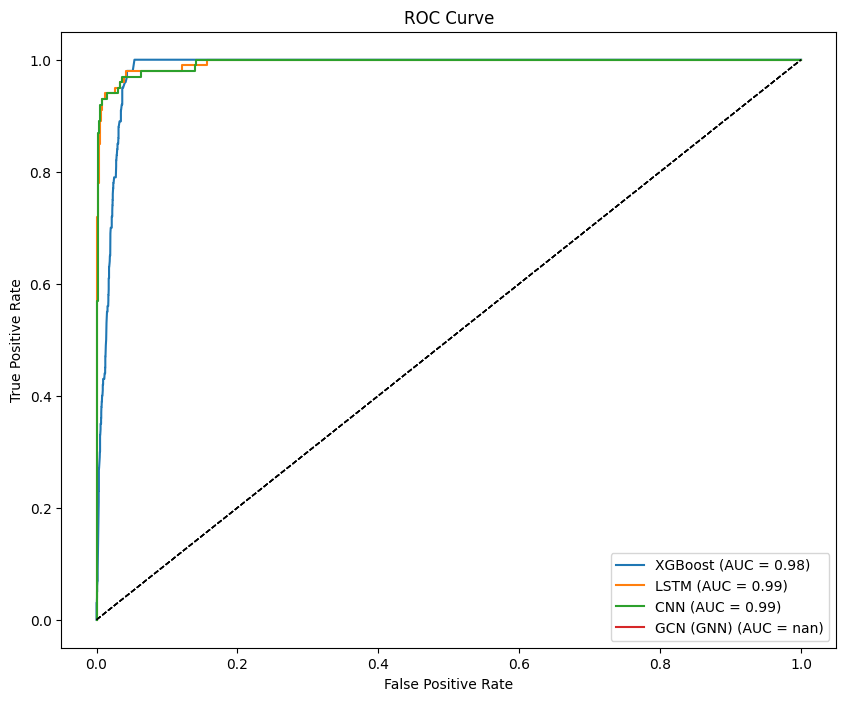

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


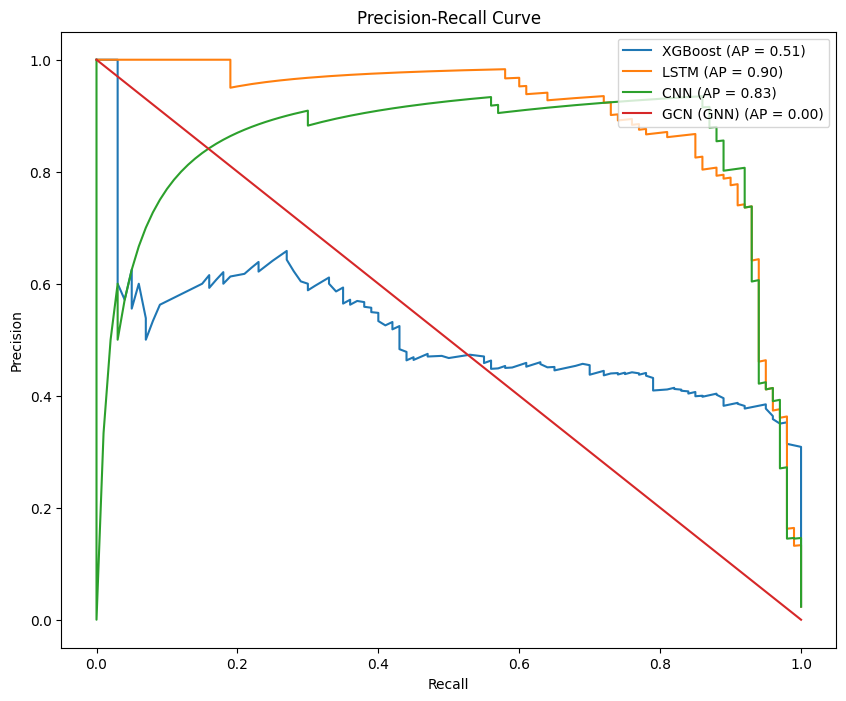

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_roc_curve(y_true, y_proba, model_name, color=None):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', color=color)
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

def plot_pr_curve(y_true, y_proba, model_name, color=None):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(recall, precision, label=f'{model_name} (AP = {ap:.2f})', color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')

# === Main plotting section ===

plt.figure(figsize=(10, 8))
plot_roc_curve(y_test, y_proba_xgb, 'XGBoost', color='C0')
plot_roc_curve(y_seq_test, y_proba_lstm, 'LSTM', color='C1')
plot_roc_curve(y_seq_test, y_proba_cnn, 'CNN', color='C2')
# Add GCN if available
if 'gcn_probs' in globals() and 'test_mask' in globals():
    # Use only test_mask indices for evaluation
    gcn_y_true = y[test_mask].cpu().numpy() if hasattr(y[test_mask], 'cpu') else y[test_mask].values
    gcn_y_proba = gcn_probs[test_mask] if hasattr(gcn_probs, '__getitem__') else gcn_probs
    plot_roc_curve(gcn_y_true, gcn_y_proba, 'GCN (GNN)', color='C3')
plt.show()

plt.figure(figsize=(10, 8))
plot_pr_curve(y_test, y_proba_xgb, 'XGBoost', color='C0')
plot_pr_curve(y_seq_test, y_proba_lstm, 'LSTM', color='C1')
plot_pr_curve(y_seq_test, y_proba_cnn, 'CNN', color='C2')
if 'gcn_probs' in globals() and 'test_mask' in globals():
    plot_pr_curve(gcn_y_true, gcn_y_proba, 'GCN (GNN)', color='C3')
plt.show()

# Step 6: Explainability with SHAP and LIME

# SHAP Analysis

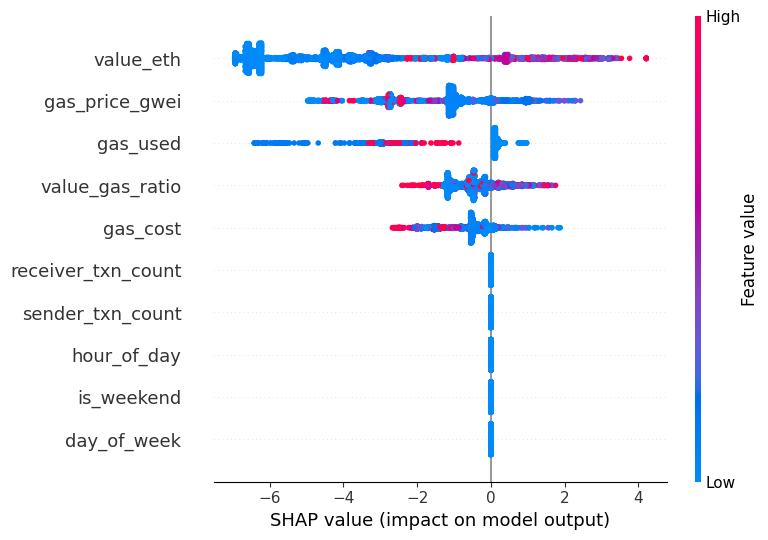

In [31]:
import shap
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)
shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=X.columns)
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0, :], X_test_scaled[0, :], feature_names=X.columns)


## LIME Analysis



In [32]:
import lime
import lime.lime_tabular
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=X.columns,
    class_names=['Normal', 'Fraud'],
    mode='classification'
)
exp = explainer_lime.explain_instance(
    X_test_scaled[0],
    xgb_model.predict_proba,
    num_features=10
)
exp.show_in_notebook()

# Step 7: Comparison & Reporting

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Model Performance Comparison:
       Model  Accuracy  Precision  Recall  F1-Score   ROC-AUC
0    XGBoost  0.958911   0.359551    0.96  0.523161  0.984659
1       LSTM  0.953723   0.334471    0.98  0.498728  0.994650
2        CNN  0.955837   0.343972    0.97  0.507853  0.994212
3  GCN (GNN)  0.967073   0.000000    0.00  0.000000       NaN


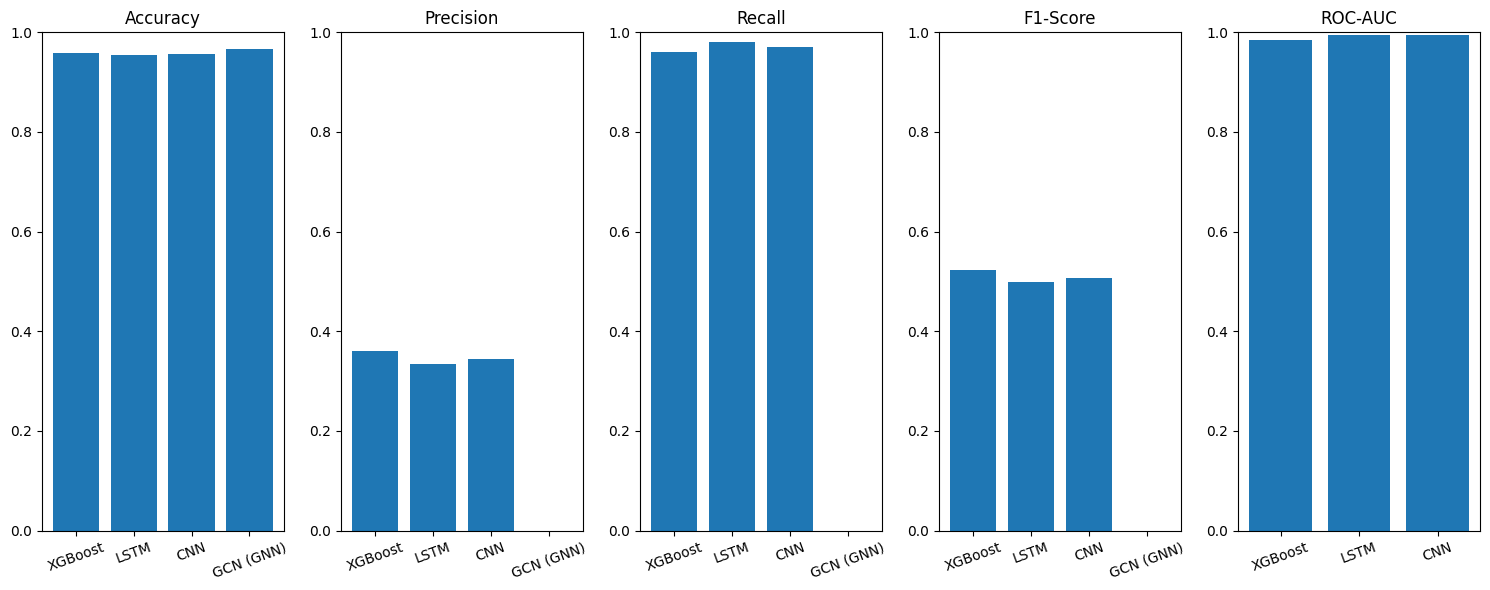

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

def evaluate_model(y_true, y_pred, y_proba, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }

# Gather results
results = [
    evaluate_model(y_test, y_pred_xgb, y_proba_xgb, 'XGBoost'),
    evaluate_model(y_seq_test, y_pred_lstm, y_proba_lstm, 'LSTM'),
    evaluate_model(y_seq_test, y_pred_cnn, y_proba_cnn, 'CNN')
]

# Add GCN/GNN if available
if 'gcn_probs' in globals() and 'test_mask' in globals():
    gcn_y_true = y[test_mask].cpu().numpy() if hasattr(y[test_mask], 'cpu') else y[test_mask].values
    gcn_y_pred = (gcn_probs[test_mask] > 0.5).astype(int) if hasattr(gcn_probs, '__getitem__') else (gcn_probs > 0.5).astype(int)
    gcn_y_proba = gcn_probs[test_mask] if hasattr(gcn_probs, '__getitem__') else gcn_probs
    results.append(evaluate_model(gcn_y_true, gcn_y_pred, gcn_y_proba, 'GCN (GNN)'))

results_df = pd.DataFrame(results)

print("Model Performance Comparison:")
print(results_df)

# Visual comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, metric in enumerate(metrics):
    plt.subplot(1, 5, i+1)
    plt.bar(results_df['Model'], results_df[metric])
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=20)
plt.tight_layout()
plt.show()